In [1]:
import tensorflow as tf 
from tensorflow.keras import layers as L 
import numpy as np 
import tensorflow_datasets as tfds

In [2]:
class IdentityBlock(tf.keras.models.Model):
  def __init__(self, filters, filter_size, **kwargs):
    super().__init__(**kwargs)
    self.conv1 = L.Conv2D(filters, filter_size, activation="relu", padding="same")
    self.bn = L.BatchNormalization()
    self.act = L.Activation("relu")
    self.conv2 = L.Conv2D(filters, filter_size, activation="relu", padding="same")
    self.add  = L.Add() 

  def call(self, inputs):
      x  = self.conv1(inputs)
      x = self.bn(x)
      x = self.act(x)
      x = self.conv1(x)
      x = self.bn(x)
      x = self.add([x, inputs])
      x = self.act(x)
      return x 



In [3]:
class MyResNet(tf.keras.models.Model):
  def __init__(self, num_classes, **kwargs): 
    super().__init__(**kwargs)
    #Initial step in resnet before the identity blocks. 
    self.conv = L.Conv2D(64, 7, padding="same")
    self.act = L.Activation("relu")
    self.bn = L.BatchNormalization() 
    self.max_pooling = L.MaxPooling2D(3)

    #identity blocks. 
    self.id1 = IdentityBlock(64, 3)
    self.id2 = IdentityBlock(64, 3 )
    
    #final global avg and softmax 
    self.gb_avg_pool = L.GlobalAveragePooling2D()
    self.out = L.Dense(num_classes, activation="softmax")
    
  def call(self, inputs): 
      x = self.conv(inputs)
      x = self.act(x)
      x = self.bn(x)
      x = self.max_pooling(x)
      x = self.id1(x)
      x = self.id2(x)
      x = self.gb_avg_pool(x)
      return self.out(x)



In [4]:
class AccBreaker(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get("acc") >= .975):
      self.model.stop_training=True
      print("Reached 97.5% validation accuracy, early stopping!")
    

In [5]:
#takes in as argument the number of classes in the classification problem. 
my_resnet = MyResNet(10)
my_resnet.compile(optimizer="adam", loss = "sparse_categorical_crossentropy", metrics = "acc")

#get the data from tfds
(x_t, y_t), (x_v, y_v) = tf.keras.datasets.mnist.load_data() 
x_t, x_v = np.expand_dims((x_t/255.), axis=-1), np.expand_dims(x_v / 255., axis=-1)  

#train the model. 
my_resnet.fit(x_t, y_t, validation_data= (x_v, y_v), epochs=20, callbacks=[AccBreaker()])

11493376/11490434 [==============================] - 0s 0us/step
Epoch 1/20
1875/1875 [==============================] - 15s 4ms/step - loss: 0.2883 - acc: 0.9293 - val_loss: 0.1355 - val_acc: 0.9619
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0481 - acc: 0.9863 - val_loss: 0.0749 - val_acc: 0.9770
Reached 97.5% validation accuracy, early stopping!


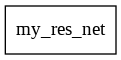

In [8]:
tf.keras.utils.plot_model(my_resnet, show_layer_names=True, show_shapes=True)

In [9]:
my_resnet.summary()

Model: "my_res_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  3200      
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
identity_block (IdentityBloc multiple                  37184     
_________________________________________________________________
identity_block_1 (IdentityBl multiple                  37184     
_________________________________________________________________
global_average_pooling2d (Gl multiple                  0